In [1]:
import sys
sys.path.append("../")
import warnings
from pathlib import Path
from ocpmodels.common.utils import make_script_trainer
import numpy as np

from ocpmodels.common.utils import (
    build_config,
    resolve,
    setup_imports,
    setup_logging,
    update_from_sbatch_py_vars,
)
from ocpmodels.common.flags import flags
from ocpmodels.common.registry import registry
import matplotlib.pyplot as plt

import lmdb
import os

import ase.io
from ase.io.trajectory import Trajectory
from ase.io import extxyz
from ase.calculators.emt import EMT
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import LBFGS
from ase.visualize.plot import plot_atoms
from ase import Atoms
from IPython.display import Image
from io import StringIO

import pickle
import json


In [2]:

data_path = "/network/scratch/s/schmidtv/ocp/datasets/ocp/dense/oc20dense.lmdb"
lmdb_path = Path(data_path)

print("File exists", os.path.isfile(data_path))

username = os.environ["USER"]
fletter = username[0]

File exists True


In [3]:
# Download mappings in data file
!mkdir -p /network/scratch/$fletter/$username/ocp/data/dense/metadata/
!wget -P /network/scratch/$fletter/$username/ocp/data/dense/metadata/ -c https://dl.fbaipublicfiles.com/opencatalystproject/data/adsorbml/oc20_dense_mappings.tar.gz 
!tar -xvf /network/scratch/$fletter/$username/ocp/data/dense/metadata/oc20_dense_mappings.tar.gz -C /network/scratch/a/ali.ramlaoui/ocp/data/dense/metadata/
!rm /network/scratch/$fletter/$username/ocp/data/dense/metadata/oc20_dense_mappings.tar.gz

--2023-11-29 16:17:39--  https://dl.fbaipublicfiles.com/opencatalystproject/data/adsorbml/oc20_dense_mappings.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.139.93, 13.226.139.126, 13.226.139.28, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.139.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5137126 (4.9M) [application/x-tar]
Saving to: ‘/network/scratch/a/ali.ramlaoui/ocp/data/dense/metadata/oc20_dense_mappings.tar.gz’

oc20_dense_mappings 100%[===================>]   4.90M  11.8MB/s    in 0.4s    

2023-11-29 16:17:40 (11.8 MB/s) - ‘/network/scratch/a/ali.ramlaoui/ocp/data/dense/metadata/oc20_dense_mappings.tar.gz’ saved [5137126/5137126]

oc20dense_compute.pkl
oc20dense_mapping.pkl
oc20dense_ref_energies.pkl
oc20dense_tags.pkl
oc20dense_targets.pkl


In [4]:
#Read mappings
import joblib
from pprint import pprint

data_path = f"/network/scratch/{fletter}/{username}/ocp/data/dense/metadata/"

compute_mappings = joblib.load(data_path + "oc20dense_compute.pkl")
print(f"Length of compute mappings: {len(compute_mappings)}")
print(f"Keys:")
pprint(compute_mappings.keys())
print(f"Example:")
pprint(list(compute_mappings.values())[0])


Length of compute mappings: 973
Keys:
dict_keys(['0_1190_0', '0_11190_86', '0_2302_72', '0_2336_45', '0_2374_49', '0_2554_20', '0_3161_13', '0_3572_18', '0_3577_7', '0_5107_96', '0_5576_5', '0_5969_37', '0_6055_19', '0_8478_44', '10_133_5', '10_1444_17', '10_394_10', '10_3099_33', '10_3099_5', '10_3353_5', '10_4609_10', '10_5863_121', '11_1573_56', '11_1728_26', '11_2154_129', '11_2773_23', '11_783_2', '12_1174_85', '12_1757_5', '12_1990_4', '12_2492_47', '12_3701_25', '12_3915_5', '12_6446_39', '12_7178_20', '12_8736_30', '12_1097_22', '13_1974_3', '13_2561_4', '13_3033_3', '13_34_2', '13_706_25', '13_734_133', '14_1662_2', '14_5218_40', '14_6259_6', '15_1204_18', '15_159_1', '15_3994_47', '15_1267_21', '15_3890_77', '15_9991_19', '16_3177_11', '16_4103_115', '16_4335_2', '16_5258_75', '16_6384_9', '16_834_196', '16_7283_37', '16_953_8', '17_2359_31', '17_2568_4', '17_2796_98', '17_405_22', '17_3066_19', '17_3068_40', '17_3555_20', '17_6587_7', '17_8286_22', '17_1107_4', '18_3043_65',

In [5]:
#Compute mappings of the LMDB file
mapping = joblib.load(data_path + "oc20dense_mapping.pkl")
print(f"Length of mappings: {len(mapping)}")
pprint(mapping.keys())
print(f"Example:")
pprint(list(mapping.values())[0])

Length of mappings: 85658
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214

In [6]:
ref_energies = joblib.load(data_path + "oc20dense_ref_energies.pkl")
print(f"Length of ref energies: {len(ref_energies)}")
pprint(ref_energies.keys())
print(f"Example:")
pprint(list(ref_energies.values())[0])

Length of ref energies: 973
dict_keys(['0_1190_0', '0_11190_86', '0_2302_72', '0_2336_45', '0_2374_49', '0_2554_20', '0_3161_13', '0_3572_18', '0_3577_7', '0_5107_96', '0_5576_5', '0_5969_37', '0_6055_19', '0_8478_44', '10_133_5', '10_1444_17', '10_394_10', '10_3099_33', '10_3099_5', '10_3353_5', '10_4609_10', '10_5863_121', '11_1573_56', '11_1728_26', '11_2154_129', '11_2773_23', '11_783_2', '12_1174_85', '12_1757_5', '12_1990_4', '12_2492_47', '12_3701_25', '12_3915_5', '12_6446_39', '12_7178_20', '12_8736_30', '12_1097_22', '13_1974_3', '13_2561_4', '13_3033_3', '13_34_2', '13_706_25', '13_734_133', '14_1662_2', '14_5218_40', '14_6259_6', '15_1204_18', '15_159_1', '15_3994_47', '15_1267_21', '15_3890_77', '15_9991_19', '16_3177_11', '16_4103_115', '16_4335_2', '16_5258_75', '16_6384_9', '16_834_196', '16_7283_37', '16_953_8', '17_2359_31', '17_2568_4', '17_2796_98', '17_405_22', '17_3066_19', '17_3068_40', '17_3555_20', '17_6587_7', '17_8286_22', '17_1107_4', '18_3043_65', '18_424_1

In [7]:
tags = joblib.load(data_path + "oc20dense_tags.pkl")
print(f"Length of tags: {len(tags)}")
pprint(tags.keys())
print(f"Example:")
pprint(list(tags.values())[0])

Length of tags: 973
dict_keys(['17_405_22', '10_4609_10', '78_8183_185', '6_8845_80', '80_3227_39', '9_3218_60', '45_7371_26', '45_241_8', '25_860_62', '74_2292_35', '7_8930_215', '69_5384_21', '7_3987_13', '7_6875_3', '8_2255_14', '40_3261_77', '6_2097_100', '16_7283_37', '71_2537_62', '68_1837_17', '7_10352_9', '6_10420_2', '72_785_14', '56_2693_37', '8_10020_72', '73_3529_3', '58_2767_46', '71_2233_67', '14_1662_2', '57_7_1', '1_1728_33', '16_6384_9', '14_6259_6', '45_7673_39', '26_10797_43', '42_6921_7', '4_2274_75', '7_9289_5', '19_1900_29', '70_3568_29', '41_6957_10', '80_9443_1', '71_6565_251', '13_734_133', '13_1974_3', '80_3628_6', '25_2632_4', '57_2719_41', '7_10319_5', '58_2501_44', '8_414_14', '71_6078_115', '6_5733_41', '14_5218_40', '9_2241_20', '26_2047_3', '71_2090_36', '1_3984_8', '8_6142_27', '52_6147_10', '6_3558_9', '71_9826_55', '71_3086_27', '4_7696_78', '8_2296_0', '80_2234_20', '6_3876_5', '6_3391_74', '0_6055_19', '71_6359_40', '7_1098_11', '19_1087_50', '41_61

In [8]:
targets = joblib.load(data_path + "oc20dense_targets.pkl")
print(f"Length of targets: {len(targets)}")
pprint(targets.keys())
print(f"Example:")
pprint(list(targets.values())[0])

Length of targets: 973
dict_keys(['0_1190_0', '0_11190_86', '0_2302_72', '0_2336_45', '0_2374_49', '0_2554_20', '0_3161_13', '0_3572_18', '0_3577_7', '0_5107_96', '0_5576_5', '0_5969_37', '0_6055_19', '0_8478_44', '10_133_5', '10_1444_17', '10_394_10', '10_3099_33', '10_3099_5', '10_3353_5', '10_4609_10', '10_5863_121', '11_1573_56', '11_1728_26', '11_2154_129', '11_2773_23', '11_783_2', '12_1174_85', '12_1757_5', '12_1990_4', '12_2492_47', '12_3701_25', '12_3915_5', '12_6446_39', '12_7178_20', '12_8736_30', '12_1097_22', '13_1974_3', '13_2561_4', '13_3033_3', '13_34_2', '13_706_25', '13_734_133', '14_1662_2', '14_5218_40', '14_6259_6', '15_1204_18', '15_159_1', '15_3994_47', '15_1267_21', '15_3890_77', '15_9991_19', '16_3177_11', '16_4103_115', '16_4335_2', '16_5258_75', '16_6384_9', '16_834_196', '16_7283_37', '16_953_8', '17_2359_31', '17_2568_4', '17_2796_98', '17_405_22', '17_3066_19', '17_3068_40', '17_3555_20', '17_6587_7', '17_8286_22', '17_1107_4', '18_3043_65', '18_424_1', '1

In [9]:
env = lmdb.open(
    str(lmdb_path),
    subdir=False,
    lock=False,
    readahead=False,
    meminit=False,
    max_readers=1,
    readonly=True,
)

n_dataset = env.stat()["entries"]
print(f"Number of examples in dataset: {n_dataset}")

Number of examples in dataset: 85658


In [10]:
# Read first example
with env.begin(write=False) as txn:
    key, value = next(iter(txn.cursor()))
    structure = pickle.loads(value)
    pprint(structure.keys())
    structure_mapping = mapping[structure["sid"]]
    ref_energy = ref_energies[structure_mapping["system_id"]]
    target_energy = [energy for energy in targets[structure_mapping["system_id"]] if energy[0] == structure_mapping["config_id"]][0]

print(f"Number of atoms: {(structure['natoms'])}")
pprint(structure)
structure["pos"].shape

['config',
 'tags',
 'natoms',
 'edge_index',
 'fixed',
 'pos',
 'cell_offsets',
 'atomic_numbers',
 'sid',
 'cell']
Number of atoms: 98
Data(pos=[98, 3], cell=[1, 3, 3], atomic_numbers=[98], natoms=98, tags=[98], edge_index=[2, 4581], cell_offsets=[4581, 3], fixed=[98], sid=0, config=1)


torch.Size([98, 3])

In [11]:
import numpy as np
pprint(f"Reference energy: {ref_energy}")
print(f"Target energy: {target_energy[1]}")

'Reference energy: -453.24573592'
Target energy: 0.19145722000001797


In [12]:
pprint("Tags are already in the structure:")
pprint(structure["tags"])

'Tags are already in the structure:'
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        2, 2])


In [13]:
pprint("This is the mapping of the structure:")
structure_mapping

'This is the mapping of the structure:'


{'system_id': '17_405_22',
 'config_id': 'rand46',
 'mpid': 'mp-20112',
 'miller_idx': (2, 0, 1),
 'shift': 0.167,
 'top': True,
 'adsorbate': '*C*C',
 'adsorption_site': array([ 2.56796181,  4.52565477, 28.3339601 ])}

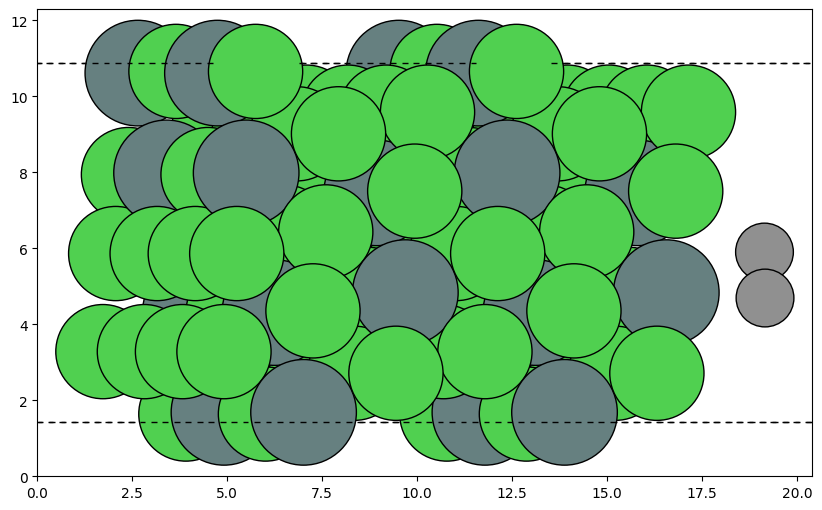

In [14]:
ase_atoms = Atoms(
    symbols=structure["atomic_numbers"],
    positions=structure["pos"],
    cell=structure["cell"].squeeze(),
    pbc=True,
)

# Plot structure
fig, ax = plt.subplots(figsize=(10, 10))
plot_atoms(ase_atoms, rotation="90x,90y,90z", show_unit_cell=True, ax=ax)
plt.show()

In [15]:
#Number of total target energies:
n = np.sum(np.array([len(targets[target]) for target in targets]))
print(f"Number of total target energies: {n}")
print(f"Number of system configurations: {n_dataset}")

Number of total target energies: 65073
Number of system configurations: 85658


We notice that there is a big difference between the total number of configurations and the total number of reported relaxation energy targets (around 20k are missing). This might be due to the fact that some DFT relaxations are rejected from the dataset because of the hypothesis detailed in the paper (might need to confirm that later).

In [16]:
from tqdm import tqdm
from collections import defaultdict
#collectionc counter

#Iterate over all examples using lmdb
with env.begin(write=False) as txn:
    for i in tqdm(range(n_dataset)):
        value = txn.get(f"{i}".encode())
        structure = pickle.loads(value)
        #######
        # Do something with the dataset
        break
        ######


  0%|          | 0/85658 [00:00<?, ?it/s]


In [17]:
import pandas as pd

columns = ["system_id", "adsorbate", "ref_energy", "config_id", "target_energy", "mpid", "global_targeet"]
df = pd.DataFrame(columns=columns)
rows = list()
for sid, config_mapping in tqdm(mapping.items()):
    system_id = config_mapping["system_id"]
    ref_energy = ref_energies[system_id]

    target_energy = [energy for energy in targets[system_id] if energy[0] == config_mapping["config_id"]]

    assert len(target_energy) <= 1, "More than one target energy found, this is strange"

    if len(target_energy) == 0:
        target_energy = None
    else:
        target_energy = target_energy[0][1]
    global_target_energy = np.min([energy[1] for energy in targets[system_id]])
    
    new_row = pd.DataFrame({"system_id": system_id, "adsorbate": config_mapping["adsorbate"], "ref_energy": ref_energy, "config_id": config_mapping["config_id"], "target_energy": target_energy, "mpid": config_mapping["mpid"], "global_target": global_target_energy}, index=[0])
    rows.append(new_row)
df = pd.concat(rows, ignore_index=True)

100%|██████████| 85658/85658 [00:44<00:00, 1937.33it/s]


In [18]:
print(f"Number of unique system ids (adsorbate+surface material): {len(df)}")
print(f"Number of unique adsorbates: {len(df['adsorbate'].unique())}")

Number of unique system ids (adsorbate+surface material): 85658
Number of unique adsorbates: 74


In [19]:
df.head(5)

,system_id,adsorbate,ref_energy,config_id,target_energy,mpid,global_target
0,17_405_22,*C*C,-453.245736,rand46,0.191457,mp-20112,-2.425444
1,10_4609_10,*CH2*O,-455.644701,rand18,-3.86779,mp-21235,-4.696501
2,78_8183_185,*NO3,-458.608610,heur6,3.977996,mp-1214064,2.977076
3,6_8845_80,*CH,-755.696586,rand64,None,mp-1220882,-2.568359
4,80_3227_39,*ONOH,-634.548378,rand65,None,mp-1221484,1.638200


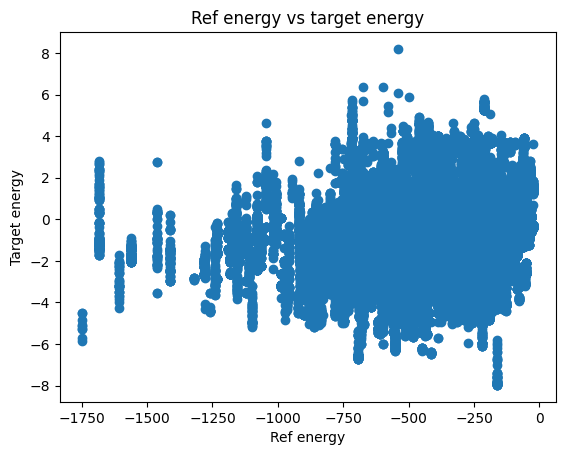

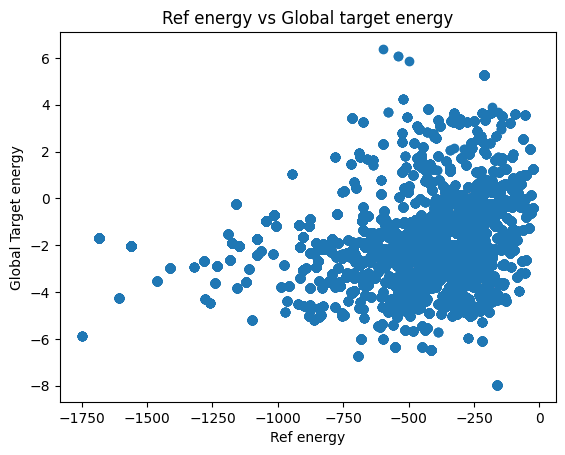

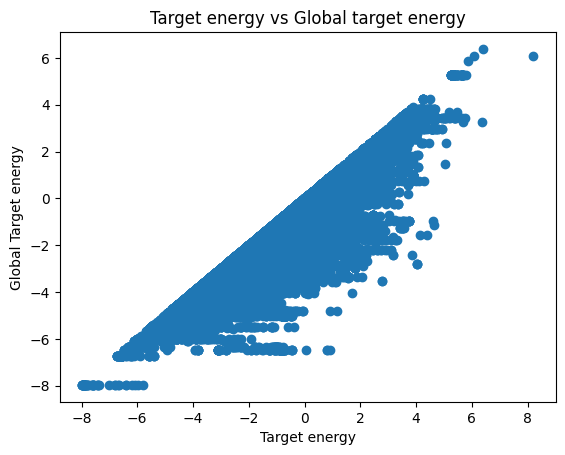

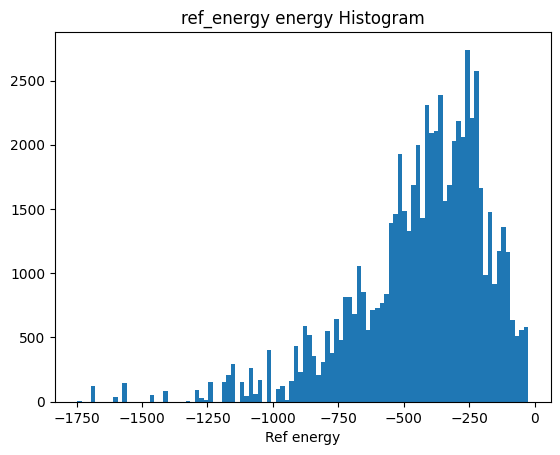

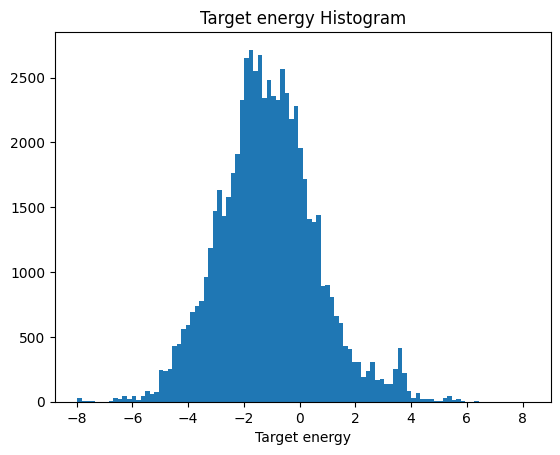

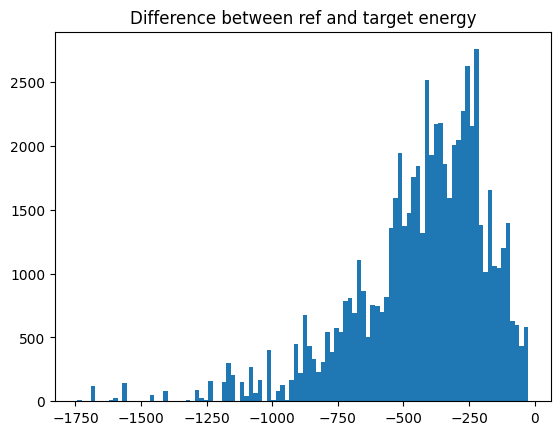

In [23]:
df_clean = df.dropna()

plt.plot(df_clean["ref_energy"], df_clean["target_energy"], "o")
plt.title("Ref energy vs target energy")
plt.xlabel("Ref energy")
plt.ylabel("Target energy")
plt.show()

plt.plot(df_clean["ref_energy"], df_clean["global_target"], "o")
plt.title("Ref energy vs Global target energy")
plt.xlabel("Ref energy")
plt.ylabel("Global Target energy")
plt.show()

plt.plot(df_clean["target_energy"], df_clean["global_target"], "o")
plt.title("Target energy vs Global target energy")
plt.xlabel("Target energy")
plt.ylabel("Global Target energy")
plt.show()

plt.hist(df_clean["ref_energy"], bins=100)
plt.title("ref_energy energy Histogram")
plt.xlabel("Ref energy")
plt.show()

plt.hist(df_clean["target_energy"], bins=100)
plt.title("Target energy Histogram")
plt.xlabel("Target energy")
plt.show()

plt.hist(df_clean["ref_energy"] - df_clean["target_energy"], bins=100)
plt.title("Difference between ref and target energy")
plt.show()


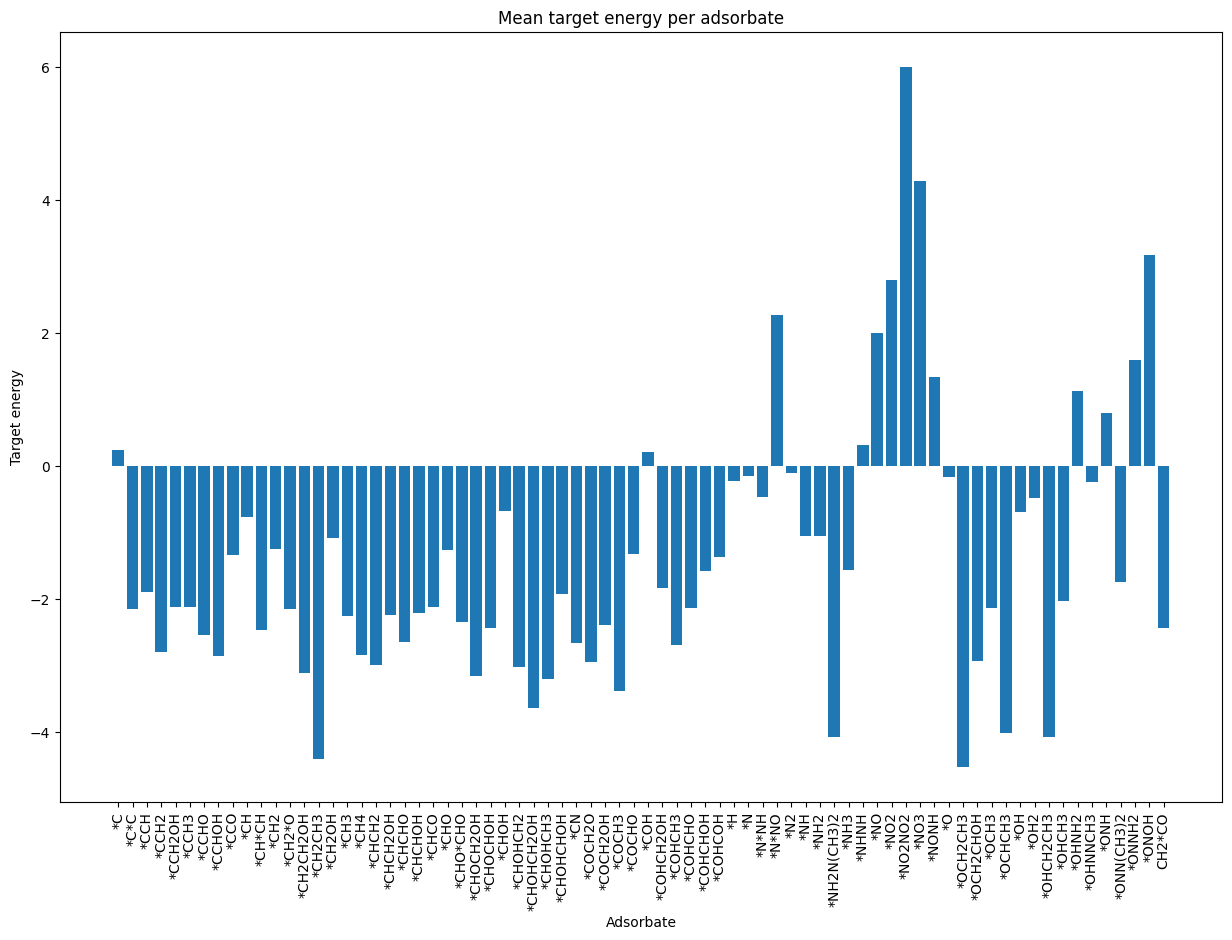

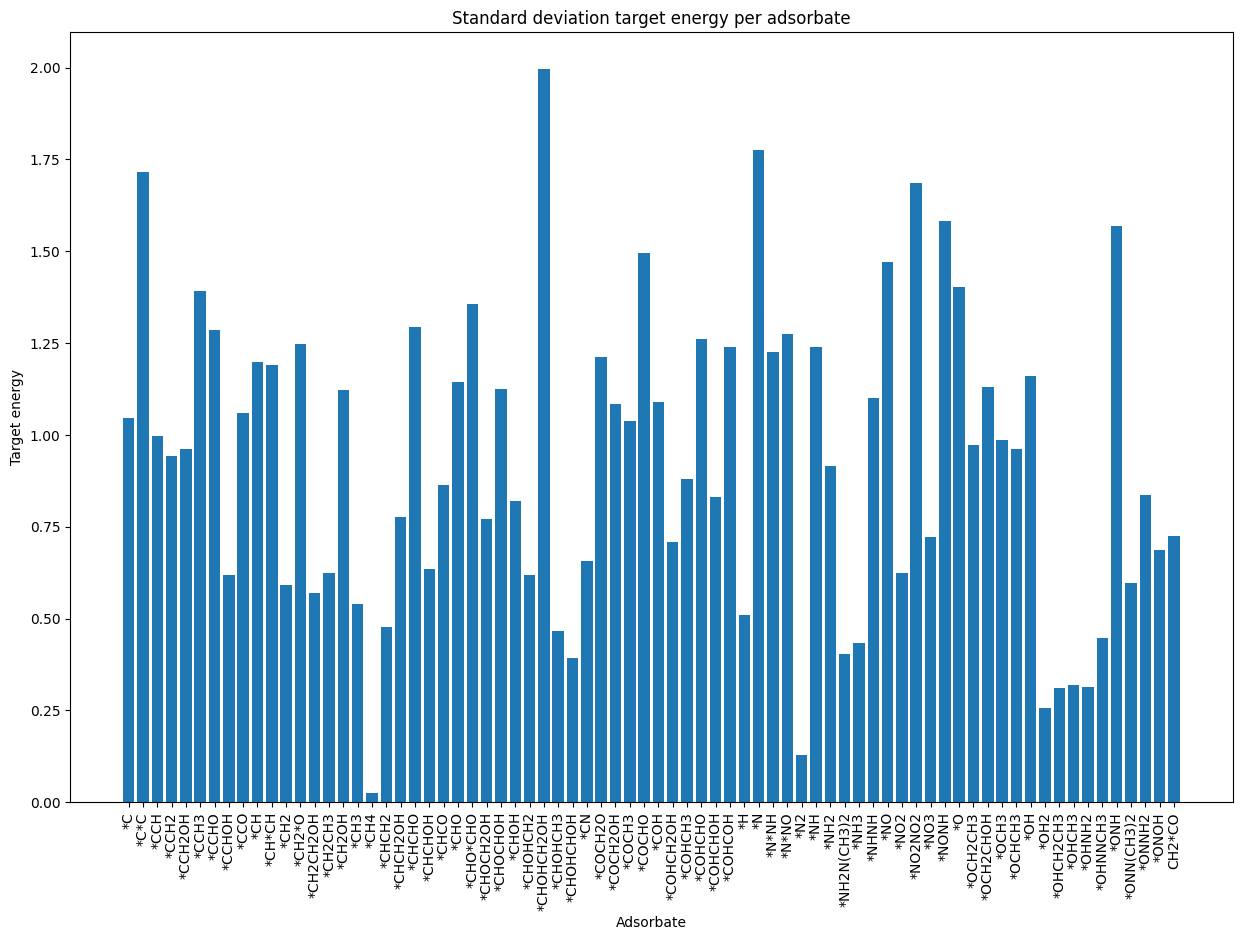

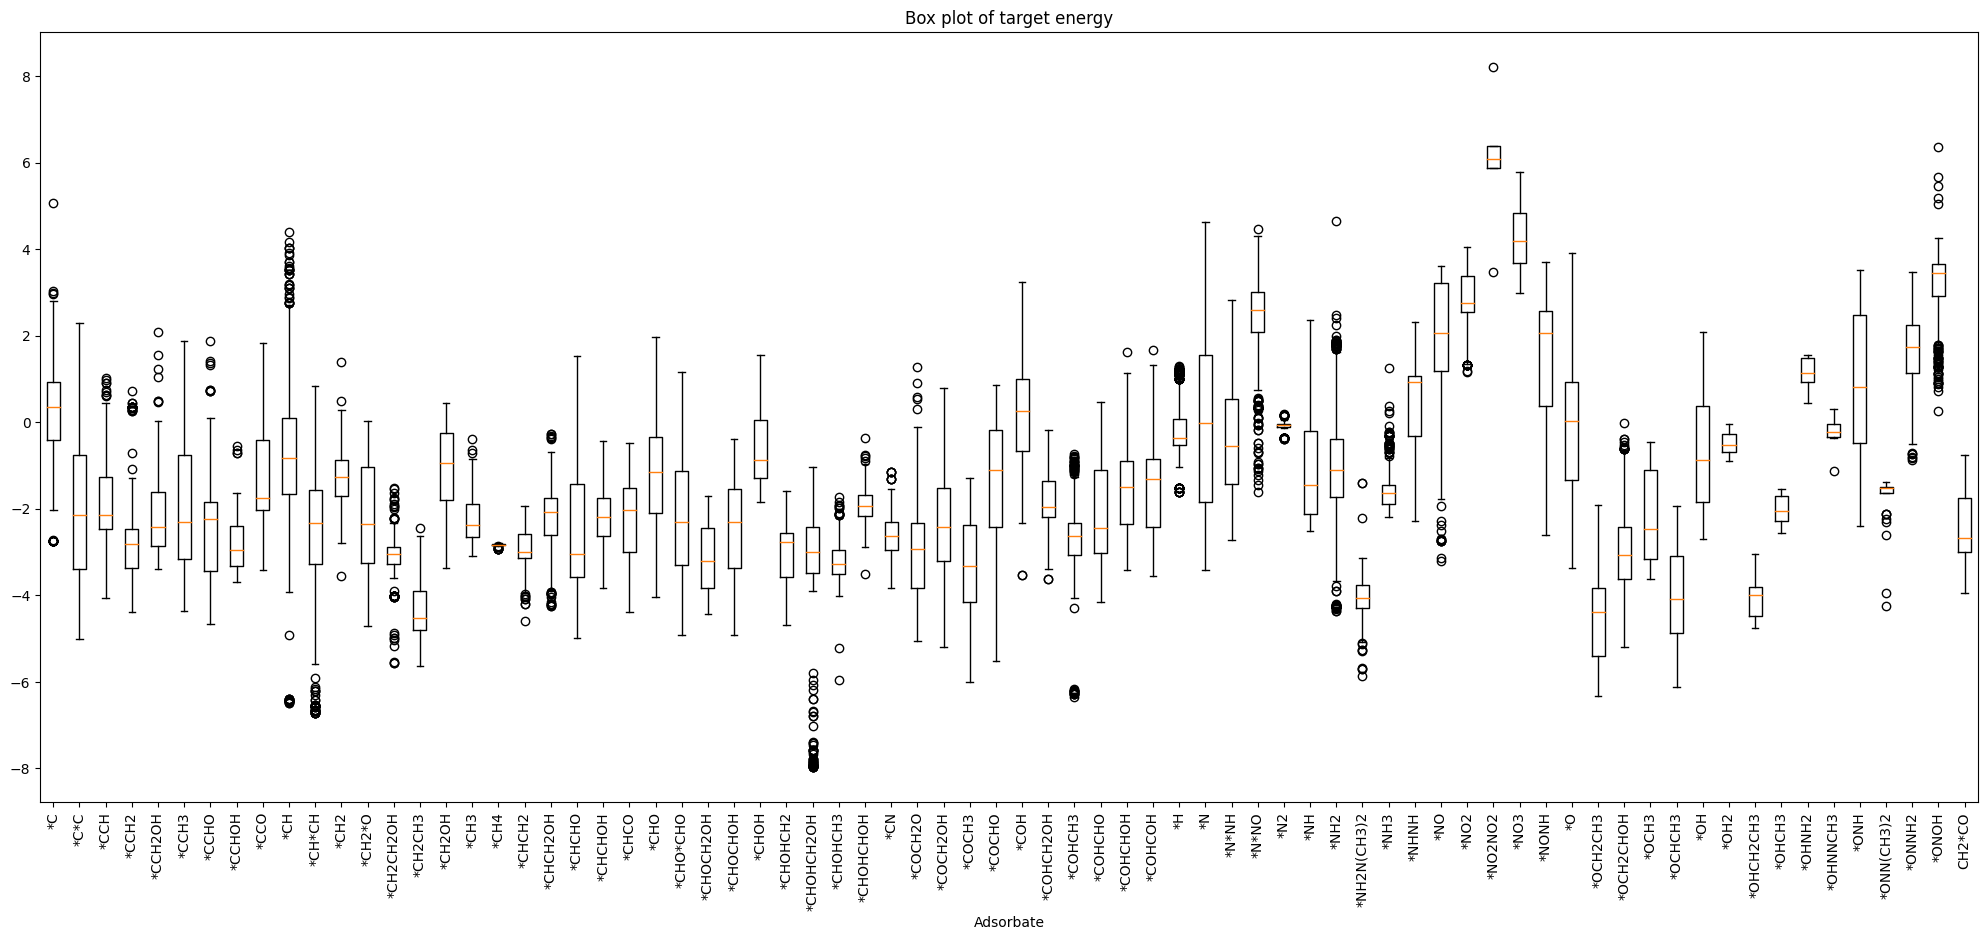

In [24]:
df_adsorbate = df_clean.groupby("adsorbate")
mean_per_adsorbate = df_adsorbate[["ref_energy", "target_energy"]].mean()
std_per_adsorbate = df_adsorbate[["ref_energy", "target_energy"]].std()
adsorbates = mean_per_adsorbate.index

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(mean_per_adsorbate.index, mean_per_adsorbate["target_energy"])
plt.title("Mean target energy per adsorbate")
plt.xlabel("Adsorbate")
plt.ylabel("Target energy")
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(std_per_adsorbate.index, std_per_adsorbate["target_energy"])
plt.title("Standard deviation target energy per adsorbate")
plt.xlabel("Adsorbate")
plt.ylabel("Target energy")
plt.xticks(rotation=90)
plt.show()

# Box plot per adsorbate
fig, _ = plt.subplots(figsize=(25, 10))
plt.boxplot(df_clean.groupby("adsorbate")["target_energy"].apply(list))
plt.xticks(np.arange(len(adsorbates))+1, adsorbates, rotation=90)
plt.title("Box plot of target energy")
plt.xlabel("Adsorbate")
plt.show()


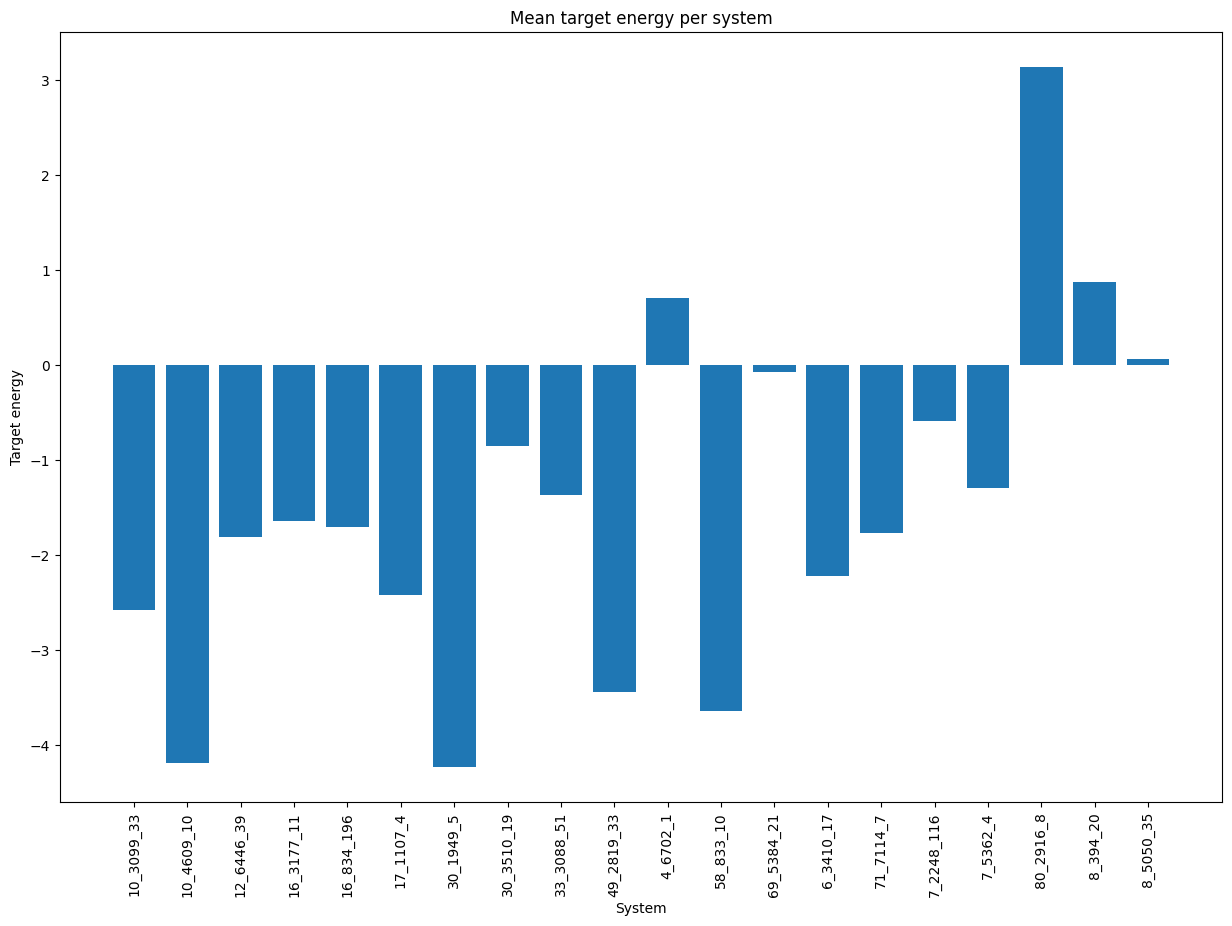

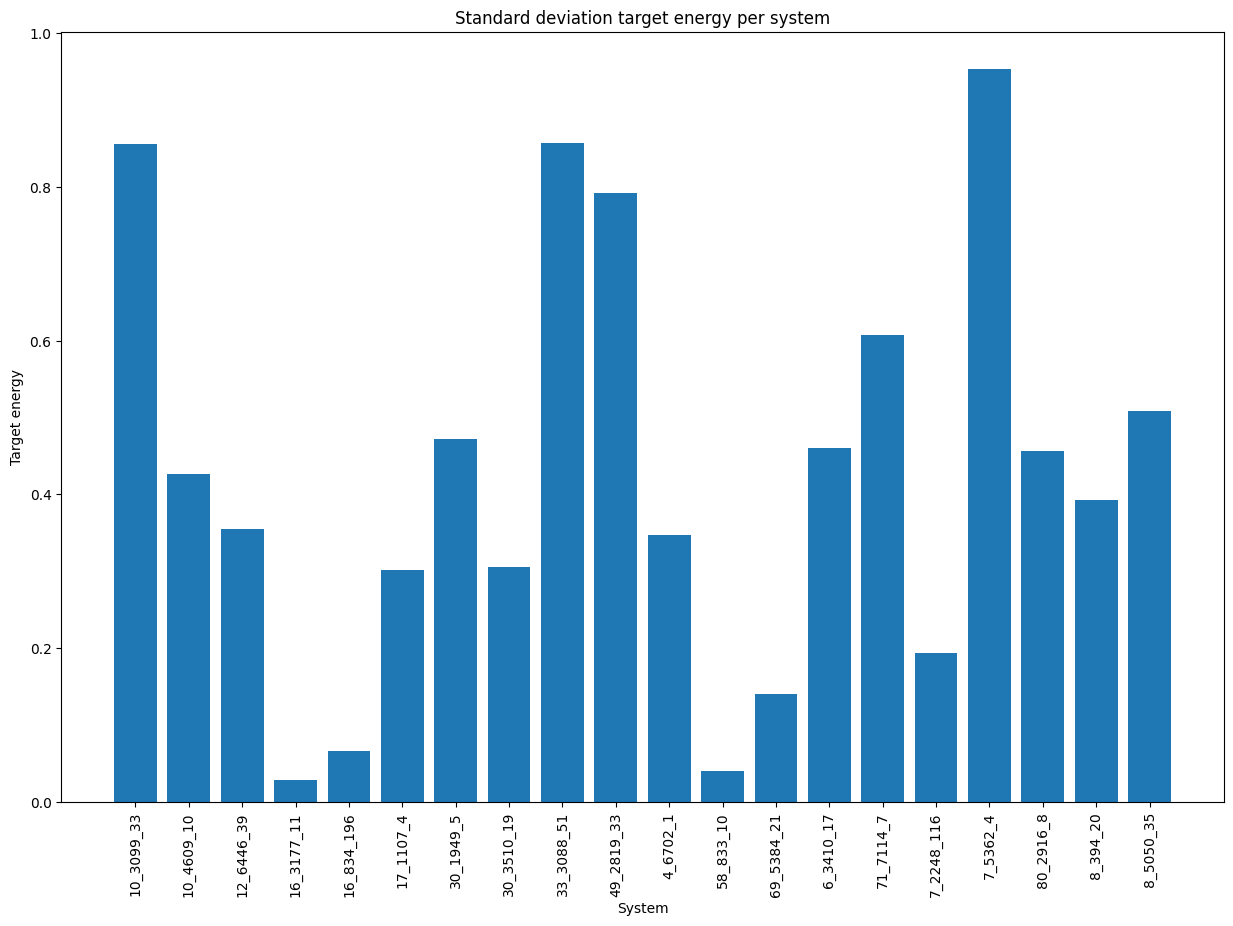

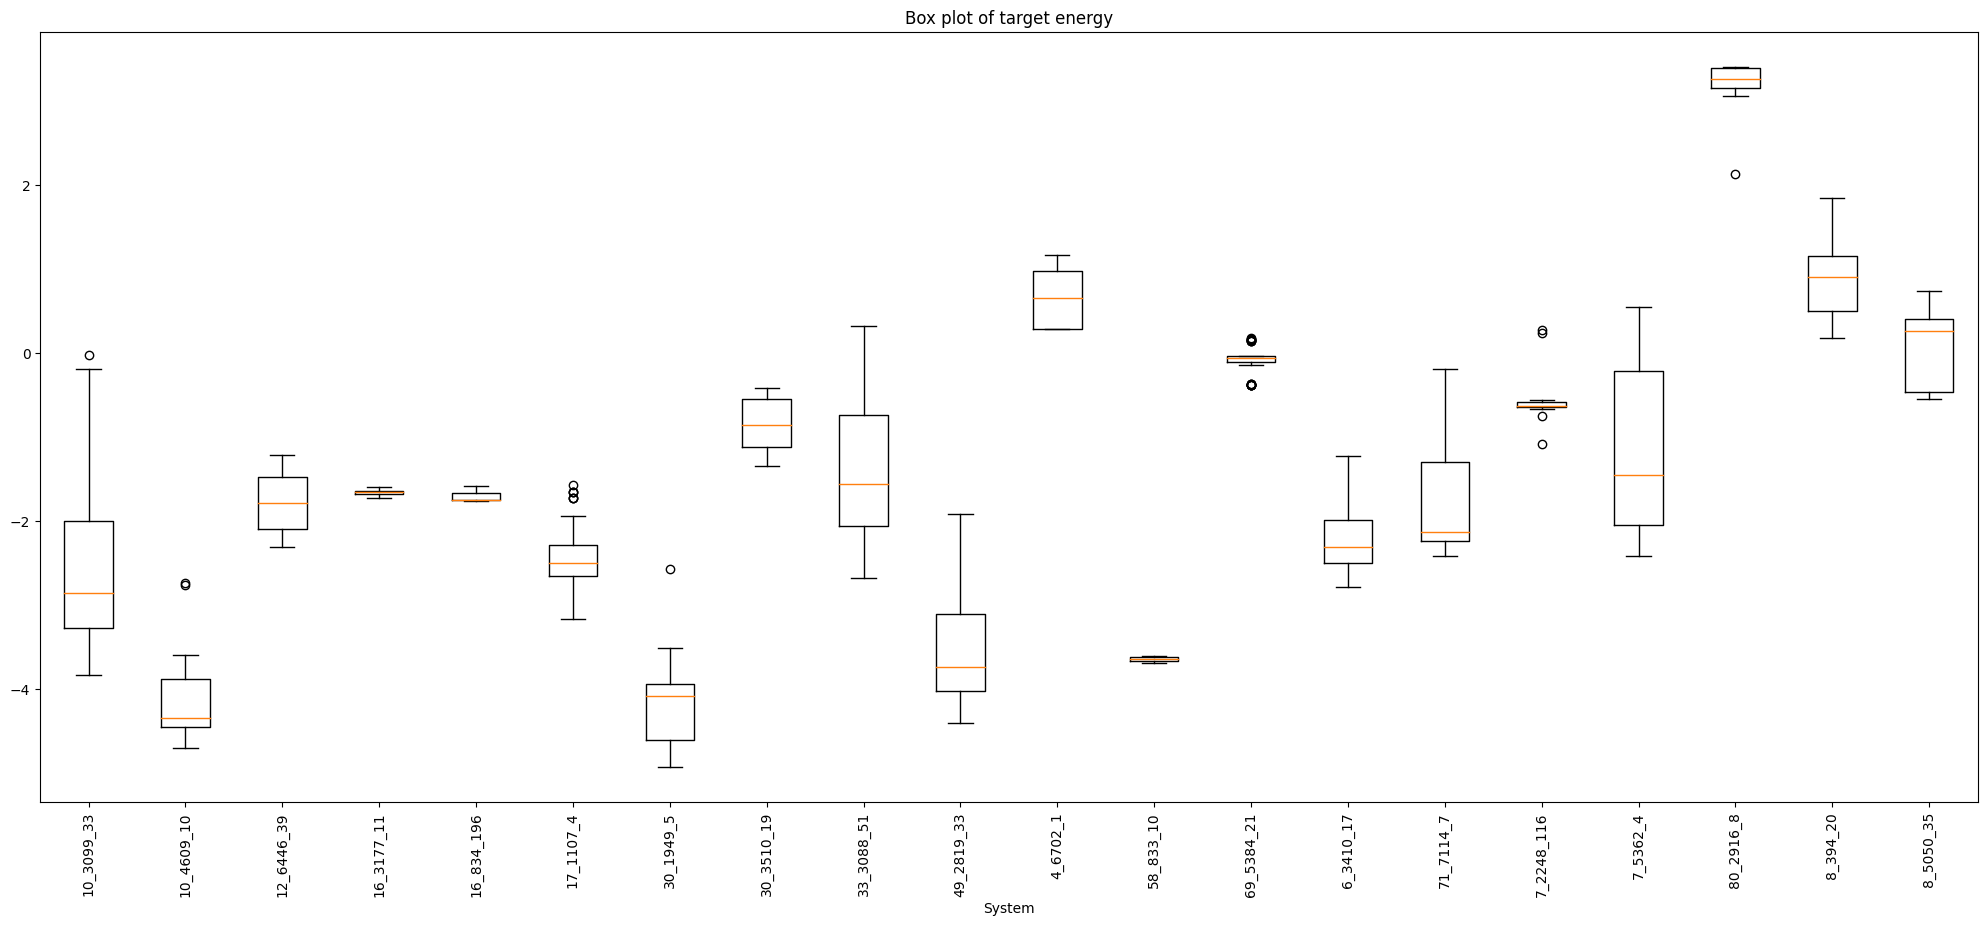

In [25]:
n = 20
systems = np.random.permutation(df_clean["system_id"].unique())[:n]
df_subset = df_clean[df_clean["system_id"].isin(systems)]
df_system = df_subset.groupby("system_id")
mean_per_system = df_system[["ref_energy", "target_energy"]].mean()
std_per_system = df_system[["ref_energy", "target_energy"]].std()
system = mean_per_system.index

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(mean_per_system.index, mean_per_system["target_energy"])
plt.title("Mean target energy per system")
plt.xlabel("System")
plt.ylabel("Target energy")
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(std_per_system.index, std_per_system["target_energy"])
plt.title("Standard deviation target energy per system")
plt.xlabel("System")
plt.ylabel("Target energy")
plt.xticks(rotation=90)
plt.show()

# Box plot per system
fig, _ = plt.subplots(figsize=(25, 10))
plt.boxplot(df_system["target_energy"].apply(list))
plt.xticks(np.arange(len(system))+1, system, rotation=90)
plt.title("Box plot of target energy")
plt.xlabel("System")
plt.show()


# Study the splits of the validation dataset and subsampling

In [26]:
df_description = df.copy().dropna()

In [27]:
metadata_path = "/network/scratch/s/schmidtv/ocp/datasets/ocp/per_ads/"

splits = ["id", "ood_ads", "ood_both", "ood_cat"]
oc20_metadata = {}
for split in splits:
    oc20_metadata[split] = json.loads(open(metadata_path + f"is2re-all-val_{split}.json", "r").read())

print(oc20_metadata["id"].keys())

dict_keys(['bulk_id', 'ads_id', 'bulk_mpid', 'bulk_symbols', 'ads_symbols', 'miller_index', 'shift', 'top', 'adsorption_site', 'class', 'anomaly', 'source', 'ds_idx'])


In [28]:
df_description["ood_ads"] = df_description["adsorbate"].isin(oc20_metadata["ood_ads"]["ads_symbols"])
df_description["ood_cat"] = df_description["mpid"].isin(oc20_metadata["ood_cat"]["bulk_mpid"])
df_description["ood_both"] = df_description["adsorbate"].isin(oc20_metadata["ood_both"]["ads_symbols"]) & df_description["mpid"].isin(oc20_metadata["ood_both"]["bulk_mpid"])
df_description["id"] = df_description["adsorbate"].isin(oc20_metadata["id"]["ads_symbols"]) & df_description["mpid"].isin(oc20_metadata["id"]["bulk_mpid"])


In [29]:
df_description

,system_id,adsorbate,ref_energy,config_id,target_energy,mpid,global_target,ood_ads,ood_cat,ood_both,id
0,17_405_22,*C*C,-453.245736,rand46,0.191457,mp-20112,-2.425444,False,True,False,False
1,10_4609_10,*CH2*O,-455.644701,rand18,-3.86779,mp-21235,-4.696501,False,False,False,True
2,78_8183_185,*NO3,-458.608610,heur6,3.977996,mp-1214064,2.977076,False,True,False,False
5,9_3218_60,*CH2,-370.171131,rand36,-0.324541,mp-1173070,-1.032876,False,True,False,False
6,45_7371_26,*COHCH3,-893.701052,rand26,-2.409899,mp-1079079,-2.978172,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
85647,71_1018_18,*NH2,-361.881773,heur11,-0.165147,mp-1023933,-1.561786,True,True,True,False
85650,6_1289_14,*CH,-703.864361,rand47,-1.79656,mp-2339,-1.952106,True,False,False,False
85652,45_7673_39,*COHCH3,-509.127619,heur45,-3.321393,mp-28997,-3.544639,False,False,False,True
85653,65_2270_86,*N*NH,-100.122685,heur151,0.666938,mp-30357,-1.304037,False,True,False,False


In [30]:
print(df_description["id"].value_counts())
print(df_description["ood_ads"].value_counts())
print(df_description["ood_both"].value_counts())
print(df_description["ood_cat"].value_counts())

id
False    49623
True     15450
Name: count, dtype: int64
ood_ads
True     33390
False    31683
Name: count, dtype: int64
ood_both
False    47434
True     17639
Name: count, dtype: int64
ood_cat
True     33872
False    31201
Name: count, dtype: int64


In [31]:
print("Number of unique systems in the ID split:")
print(len(df_description[df_description["id"]]["system_id"].unique()))

Number of unique systems in the ID split:
244


In [ ]:
lmdb_folder_path =  Path("/network/scratch/s/schmidtv/ocp/datasets/ocp/is2re/all/val_id/")
list_files = list(lmdb_folder_path.glob("*.lmdb"))
lmdb_path = list_files[0]

env_oc = lmdb.open(
    str(lmdb_path),
    subdir=False,
    lock=False,
    readahead=False,
    meminit=False,
    max_readers=1,
    readonly=True,
)

with env_oc.begin(write=False) as txn:
    key, value = next(iter(txn.cursor()))
    structure = pickle.loads(value)
    # There is an issue reading the structure

print(structure.y_init)
print(structure.y_relaxed)
env_oc.close()

8.067705849999982
-0.40190949000003684


In [ ]:
# Isolate splits
for split in splits:
    !mkdir -p /network/scratch/s/schmidtv/ocp/datasets/ocp/dense/{split}/
    !rm -rf /network/scratch/s/schmidtv/ocp/datasets/ocp/dense/{split}/oc20dense_{split}.lmdb
    lmdb_split_path = f"/network/scratch/s/schmidtv/ocp/datasets/ocp/dense/{split}/oc20dense_{split}.lmdb"

    print(f"Creating lmdb file for split: {split}")

    # Open the new file with the same config as the original env
    env_split = lmdb.open(
        str(lmdb_split_path),
        subdir=False,
        map_size=1e12,
        readonly=False,
    )

    #Iterate over all examples using lmdb
    with env.begin(write=False) as txn:
        with env_split.begin(write=True) as txn_split:
            for i, (j, element) in tqdm(enumerate(zip(df_description[df_description[split]].index, df_description[df_description[split]].to_dict("records")))):
                value = txn.get(f"{j}".encode())
                structure = pickle.loads(value)
                structure["y_init"] = element["ref_energy"]
                structure["y_relaxed"] = element["target_energy"]
                structure["system_id"] = element["system_id"]
                structure["global_target"] = element["global_target"]
                value = pickle.dumps(structure)
                txn_split.put(f"{i}".encode(), value)

    env_split.sync()
    env_split.close()




/tmp/ipykernel_29082/1885659139.py:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  env_split = lmdb.open(


Creating lmdb file for split: id


15450it [00:17, 878.79it/s]


Creating lmdb file for split: ood_ads


/tmp/ipykernel_29082/1885659139.py:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  env_split = lmdb.open(
33390it [01:21, 409.82it/s]


Creating lmdb file for split: ood_both


/tmp/ipykernel_29082/1885659139.py:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  env_split = lmdb.open(
17639it [00:22, 776.16it/s]


Creating lmdb file for split: ood_cat


/tmp/ipykernel_29082/1885659139.py:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  env_split = lmdb.open(
33872it [01:34, 359.45it/s]


In [ ]:
lmdb_folder_path =  Path("/network/scratch/s/schmidtv/ocp/datasets/ocp/dense/id/")
list_files = list(lmdb_folder_path.glob("*.lmdb"))
lmdb_path = list_files[0]

env_oc = lmdb.open(
    str(lmdb_path),
    subdir=False,
    lock=False,
    readahead=False,
    meminit=False,
    max_readers=1,
    readonly=True,
)

with env_oc.begin(write=False) as txn:
    key, value = next(iter(txn.cursor()))
    structure = pickle.loads(value)
    # There is an issue reading the structure

print(structure.y_init)
print(structure.y_relaxed)
env_oc.close()

-455.64470066999996
-3.8677901800000427
